# Prediction of User Reactions
We want to predict:
* How to get high score/consensus (upvotes - downvotes)
* How to be controversial (upvotes + downvotes)  
in the comments.

I won't:
* Determine the average score of a user/author and use this as information. Because this is not helpful once we have a user with no earlier comments.

### Import data

In [29]:
%matplotlib inline
import re
from time import time
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv')
df_com = pd.read_csv('comments_2017_09.csv')#.sample(100000) # crop because battery life
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

### Prepare features

In [30]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
#df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

df_art['header_len'] = df_art['header'].apply(lambda x: len(x))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# Remove rows with missing values
# use .count() to check for missing values
df_merge.dropna(axis=0, how='any', inplace=True)

# Get order of comments per article
df_merge = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
#    group['art_first_weekday']
    # Remove those very late comments, after x hours
    #group = group[group['time_since_first'] < 36]
    
    # I'm not sure if this is cheating and discloses too much information
    for col in ['vup', 'vdo', 'con_len']:
        group['art_' + col + '_max'] = group[col].max()
        group['art_' + col + '_min'] = group[col].min()
        group['art_' + col + '_mean'] = group[col].mean()
    
    # TODO add more info here
    return group

# Creating "copy" to make next cell independent
df_merge = df_merge.apply(get_time_since_first)
df_merge.head(10)[['tId', 'art_vup_max', 'art_vup_min', 'art_vup_mean']]

,tId,art_vup_max,art_vup_min,art_vup_mean
280671,10003016,602,0,166.667
280662,10003016,602,0,166.667
280668,10003016,602,0,166.667
280666,10003016,602,0,166.667
280655,10003016,602,0,166.667
280663,10003016,602,0,166.667
280664,10003016,602,0,166.667
280667,10003016,602,0,166.667
280672,10003016,602,0,166.667
280670,10003016,602,0,166.667


### Trying to remove skew
__Rescaling__: Add or subtract a constant and then multiply or divide by a constant.  
__Normalizing__: Dividing by a norm of the vector, e.g. make Euclidean length equal to one. Sometimes make all elements lie in [0, 1].  
__Standardizing__: Subtracting a measure of location and dividing by a measure of scale. Eg. subtract the mean and divide by the std, thereby obtaining a standard normal distribution.

These terms are sometimes used interchangeably.

It's usually better to have the input values centered around zero, unless the output activation function has a range of [0, 1] (neural networks).

In [31]:
"""
temp = df_merge[['aut']].groupby('aut').size().reset_index()
temp = temp.rename(columns = {0: 'user_n_comments'})

temp2 = pd.get_dummies(df_merge[['aut', 'weekday']], prefix='wd_', columns=['weekday', 'hour'])
temp = temp.merge(temp2).reset_index()
df = df_merge.merge(temp, on='aut')
"""
#print(len(df))
#df = df_merge.merge(temp2, left_index=True, right_index=True)
#print(df.head(2)[['tId', 'weekday', 'wd__1']])
#temp2.head(2)
#temp2 = pd.get_dummies(df_merge[['cId', 'hour']], prefix='wd_', columns=['hour'])
#temp2.head(1)
#df = df.merge(temp2, left_index=True, right_index=True) 
#df.head(1)

"\ntemp = df_merge[['aut']].groupby('aut').size().reset_index()\ntemp = temp.rename(columns = {0: 'user_n_comments'})\n\ntemp2 = pd.get_dummies(df_merge[['aut', 'weekday']], prefix='wd_', columns=['weekday', 'hour'])\ntemp = temp.merge(temp2).reset_index()\ndf = df_merge.merge(temp, on='aut')\n"

In [32]:
import math

#temp2 = pd.get_dummies(temp[(temp['user_n_comments']<100) & (temp['user_n_comments']>50)], prefix='user', columns=['aut'])
#print("users with certain amount of comments: ", len(temp2))
temp2 = pd.get_dummies(df_merge[['cId', 'weekday']], prefix='wd_', columns=['weekday'])
# Merge here first because of index!
df = df_merge.merge(temp2, left_index=True, right_index=True) 
temp2 = pd.get_dummies(df_merge[['cId', 'hour']], prefix='hour_', columns=['hour'])
df = df.merge(temp2, left_index=True, right_index=True) 

# User based information
temp = df_merge[['aut']].groupby('aut').size().reset_index()
temp = temp.rename(columns = {0: 'user_n_comments'})
df = df.merge(temp, on='aut')

df['con_n_periods'] = df['con'].apply(lambda x: len(x.split('.')))

def sgn(x):
    if x == 0: return 0
    else: return x/abs(x)
# Removes left/right skew 
for col in ['weekday_fl', 'con_len', 'text_len', 'time_since_first', 
            'num_comments', 'user_n_comments', 'con_n_periods',
            'score', 'contr', 'header_len', 'con_num_words', 'text_num_words']:
    df[col + '_trans'] = df[col].apply(lambda x: sgn(x)*math.log(abs(x) + 1))

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# I removed very weak correlations to "score" and "contr"
cols = ['score', 'score_trans', 'vup', 'vdo', 'weekday', 'hour', 'weekday_fl',
       'con_len_trans', 'text_len_trans', 'con_num_words_trans', 'user_n_comments',
        'text_num_words_trans', 'num_comments', 'num_comments_trans',
       'time_since_first_trans', 'header_len_trans', 'con_n_periods',
        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
       'wd__0', 'wd__1', 'wd__2', 'hour__17', 'hour__18']#'user_Amina123', 'user_Chris', 'user_Dani']
# Get pearson co-efficients
df[cols].corr()

#df.hist('user_score_mean_trans')

#for c in cols:
#    print(c)
#    print(df[np.isnan(df[col])].head(3))

,score,score_trans,vup,vdo,weekday,hour,weekday_fl,con_len_trans,text_len_trans,con_num_words_trans,...,cat_schweiz,cat_finance,cat_sport,cat_wissen,cat_ausland,wd__0,wd__1,wd__2,hour__17,hour__18
score,1.000,0.476,0.952,0.031,-0.006,-0.004,-0.006,0.013,0.005,0.010,...,0.036,-0.030,-0.023,-0.016,0.005,0.001,0.016,-0.018,0.005,0.008
score_trans,0.476,1.000,0.351,-0.319,-0.005,-0.007,-0.006,0.034,-0.003,0.030,...,0.024,-0.014,-0.035,-0.006,-0.008,-0.006,0.016,-0.008,0.001,0.006
vup,0.952,0.351,1.000,0.334,-0.001,-0.000,-0.001,0.019,0.007,0.017,...,0.043,-0.044,-0.017,-0.021,0.018,0.002,0.014,-0.023,0.007,0.010
vdo,0.031,-0.319,0.334,1.000,0.014,0.012,0.015,0.025,0.009,0.024,...,0.030,-0.051,0.015,-0.021,0.044,0.003,-0.002,-0.019,0.008,0.010
weekday,-0.006,-0.005,-0.001,0.014,1.000,0.010,0.993,-0.005,-0.037,-0.006,...,-0.021,-0.019,0.016,0.022,-0.019,-0.565,-0.425,-0.219,0.001,0.002
hour,-0.004,-0.007,-0.000,0.012,0.010,1.000,0.130,-0.049,-0.040,-0.049,...,-0.040,-0.016,0.018,0.038,0.006,-0.022,0.023,-0.007,0.159,0.196
weekday_fl,-0.006,-0.006,-0.001,0.015,0.993,0.130,1.000,-0.011,-0.041,-0.012,...,-0.025,-0.020,0.018,0.027,-0.018,-0.563,-0.419,-0.218,0.020,0.026
con_len_trans,0.013,0.034,0.019,0.025,-0.005,-0.049,-0.011,1.000,0.069,0.989,...,0.049,0.033,-0.053,-0.008,0.016,-0.013,-0.001,0.011,-0.017,-0.015
text_len_trans,0.005,-0.003,0.007,0.009,-0.037,-0.040,-0.041,0.069,1.000,0.067,...,0.177,0.052,-0.014,-0.018,0.071,0.019,-0.006,0.014,-0.021,-0.017
con_num_words_trans,0.010,0.030,0.017,0.024,-0.006,-0.049,-0.012,0.989,0.067,1.000,...,0.044,0.032,-0.047,-0.009,0.012,-0.013,-0.001,0.012,-0.017,-0.016


### Prepare and split for model

In [36]:
# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

X = df.drop(['score', 'contr', 'vup', 'vdo'], axis=1)
y = df['score']

from sklearn.model_selection import train_test_split, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print("total data: ", len(X))

def plot_learning_curve(estimator, X, y, cv=None, ylim=None, n_jobs=1, train_sizes=np.linspace(.5, 1.0, 2)):
    plt.figure()
    plt.title('Learning curve')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples'); plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

total data:  287500


### Model 

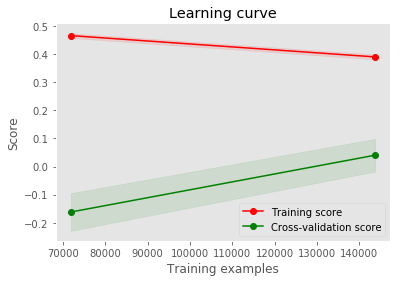

R^2: 0.066
Mean absolute err: 38.108411
Mean squared err: 14067.238038


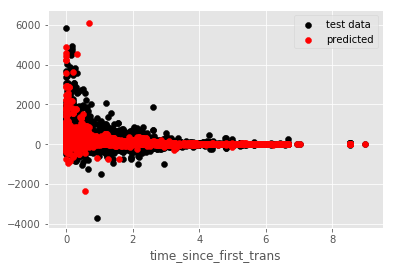

Done in 15.510860 min.


0

In [42]:
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
ngram_range = (1, 1)
cat_cols = [col for col in list(df.columns) if col.startswith('wd_') or col.startswith('art_') or col.startswith('hour_')]
st = time()
def no_numbers(x):
    return re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        [
            # comment + user information
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['con_len_trans', 'num_comments', 
                         'time_since_first_trans',# 'con_num_words',
                          'user_n_comments_trans', #'con_n_periods_trans',
                        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
                         'cat_panorama', 'cat_community', 'cat_people', 'cat_digital'
                   #     ])),
                        ] + cat_cols)),
              #  ('scaler', StandardScaler()),
             #   ('reduce_dim', PCA()),
            ])),

            ('words_content', Pipeline([
                ('selector', ItemSelector(key='con')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
             #   ('best', TruncatedSVD(n_components=30)),
            ])),
            
            ('words_title', Pipeline([
                ('selector', ItemSelector(key='tit')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
              #  ('best', TruncatedSVD(n_components=30)),
            ])),
            
            # article information
            ('words_header', Pipeline([
                ('selector', ItemSelector(key='header')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
              #  ('best', TruncatedSVD(n_components=30)),
            ])),
            
            ('words_subheader', Pipeline([
                ('selector', ItemSelector(key='sub')),
                ('tfidf', TfidfVectorizer(min_df=2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
                ('best', TruncatedSVD(n_components=30)),
            ])),
            
            ('words_text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer(min_df=0.2, max_df=0.7, preprocessor=no_numbers, ngram_range=ngram_range)),
               # ('best', TruncatedSVD(n_components=20)),
            ])),
        ], n_jobs=-1
    )),
    ('reduce_features', SelectKBest(f_regression, k=40)),
    #('reduce_dim', TruncatedSVD(n_components=100)),
    #('model', MLPRegressor(max_iter=50, hidden_layer_sizes=(100,)))
    ('model', GradientBoostingRegressor(n_estimators=100, learning_rate=1.5, max_depth=3))
])

# Just choose what you want to do
if True:
    plot_learning_curve(model, X, y, cv=2, n_jobs=-1)
    plt.show()

if True:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R^2: %1.3f" % r2_score(y_test, y_pred))
    #print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
    print("Mean absolute err: {:3f}".format(mean_absolute_error(y_test, y_pred)))
    print("Mean squared err: {:3f}".format(mean_squared_error(y_test, y_pred)))
    # Residual plot
    # time_since_first because it seems to have some influence (see feature importance below)
    X_res = X_test['time_since_first_trans']
    plt.scatter(X_res, y_test, color='black', label='test data')
    plt.scatter(X_res, y_pred, color='red', label='predicted')
    plt.xlabel('time_since_first_trans')
    plt.legend(); plt.show()

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        'model__hidden_layer_sizes':[(50,), (100,), (200,), (100, 50)]
#        'model__alpha': np.logspace(-1, 4, 6),
                 }
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)

    print(grid.best_params_)
    
print('Done in {:2f} min.'.format((time() - st)/60))
# Make yourself noticeable to human
import os; os.system('say "this is dave: your program has finished."')

### Summary so far
Neural networks: R^2 = 0.39 (old try)  
GBRF: R^2 = 0.45  
ngram range (1, 2): 0.37  ngram range (1, 1): 0.366   
adding more stop words: gives a small increase

So far: still high variance, overall score not that good.

The models improve slightly with more data. The problem is that I may not have enough data yet (250k comments).

TODO:  
How to extract more information? How to use user behaviour? Use collaborative filtering?  
Save trained model, make a prediction function where it's easy to input data to try around with score prediction.

In [35]:
# Try to find out which features are not important
# It seems that the text features are rather important

fi = model.named_steps['model'].feature_importances_
"""
print(['con_len_trans', 'num_comments', 
                         'time_since_first_trans',# 'con_num_words',
                          'user_n_comments_trans', #'con_n_periods_trans',
                        'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland',
                         'cat_panorama', 'cat_community', 'cat_people', 'cat_digital'
                        ] + cat_cols)
#print(fi)
"""
print(len(fi[:-120]))
print('content')
print(fi[-120:-90])
print('tit')
print(fi[-90:-60])
print('sub')
print(fi[-60:-30])
print('text')
print(fi[-30:])

['con_len_trans', 'num_comments', 'time_since_first_trans', 'user_n_comments_trans', 'cat_schweiz', 'cat_finance', 'cat_sport', 'cat_wissen', 'cat_ausland', 'cat_panorama', 'cat_community', 'cat_people', 'cat_digital', 'art_vup_max', 'art_vup_min', 'art_vup_mean', 'art_vdo_max', 'art_vdo_min', 'art_vdo_mean', 'art_con_len_max', 'art_con_len_min', 'art_con_len_mean', 'wd__0', 'wd__1', 'wd__2', 'wd__3', 'wd__4', 'wd__5', 'wd__6', 'hour__0', 'hour__1', 'hour__2', 'hour__3', 'hour__4', 'hour__5', 'hour__6', 'hour__7', 'hour__8', 'hour__9', 'hour__10', 'hour__11', 'hour__12', 'hour__13', 'hour__14', 'hour__15', 'hour__16', 'hour__17', 'hour__18', 'hour__19', 'hour__20', 'hour__21', 'hour__22', 'hour__23']
0
content
[]
tit
[]
sub
[  4.07977434e-01   1.10340081e-01   2.89355434e-02   1.33963602e-01
   4.71128344e-02   1.64685038e-02   7.21665989e-02   1.77734221e-02
   3.35282865e-03   0.00000000e+00   9.59980109e-03   1.20942076e-02
   0.00000000e+00   3.40846765e-04   1.09780726e-02   7.839